# BDA project "Pump It Up"

- Анастасия Барковая
- Варвара Михайлова
- Анна Снигирева

# 1. Проблема

В соответствии с [water.org ](https://water.org ), 4 миллиона человек в Танзании не имеют доступа к улучшенному источнику безопасной воды.

Люди, живущие в таких условиях, тратят значительное количество времени на поездки на большие расстояния, чтобы набрать воды в пунктах сбора воды.

Точное предсказание того, функционируют насосы или нет, действительно важно, поскольку люди подвергаются риску ухудшения здоровья или даже смерти от обезвоживания.

![image.png](attachments/image.png)

Используя данные Taarifa и Министерства водного хозяйства Танзании, мы должны понимать, какие насосы исправны, какие нуждаются в некотором ремонте, а какие вообще не работают. Прогноз будет основан на ряде переменных, касающихся того, какой тип насоса работает, когда он был установлен и как им управляют. Четкое понимание того, какие пункты водоснабжения выйдут из строя, может улучшить операции по техническому обслуживанию и обеспечить доступность чистой питьевой воды для населения по всей Танзании.

[Ссылка на конкурс](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table )

# 2. Подгрузка датасета

In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
try:
    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
except:
    !pip install cartopy
    import cartopy.feature as cfeature
    import cartopy.crs as ccrs

In [54]:
X = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv", index_col=0)
y = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv", index_col=0)
assert (X.index == y.index).all()

In [55]:
pd.options.display.max_columns = 41
y.head(5)

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


Посмотрим, сколько всего количественных и категориальных признаков

In [56]:
cat_features = 0
numeric_features = 0
for column, tp in X.dtypes.items():
    if str(tp) == 'object':
        cat_features += 1
    else:
        numeric_features += 1
print(f'There are {cat_features} categorial features and {numeric_features} numeric features.')

There are 30 categorial features and 9 numeric features.


Посмотрим, сколько N/A признаков

In [57]:
y.isna().sum()

status_group    0
dtype: int64

In [58]:
categorial_nan_count = X.select_dtypes(include=['object']).isna().sum()
numeric_nan_count = X.select_dtypes(exclude=['object']).isna().sum()
print(f'NaN in Categorial:\n{(categorial_nan_count != 0).sum()}')
print(f'NaN in Numerics:\n{(numeric_nan_count != 0).sum()}')


NaN in Categorial:
7
NaN in Numerics:
0


Как видим, NaN встречается только в категориальных признаках, поэтому заменим строкой "None"

In [59]:
X.fillna(value="None", inplace=True)

Составим общую таблицу, соединив X и y

In [60]:
df = pd.merge(X, y, on='id', how='inner')
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,None,GeoData Consultants Ltd,Other,None,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,None,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,None,None,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Посмотрим, какое распределение насосов каждого типа по глубине

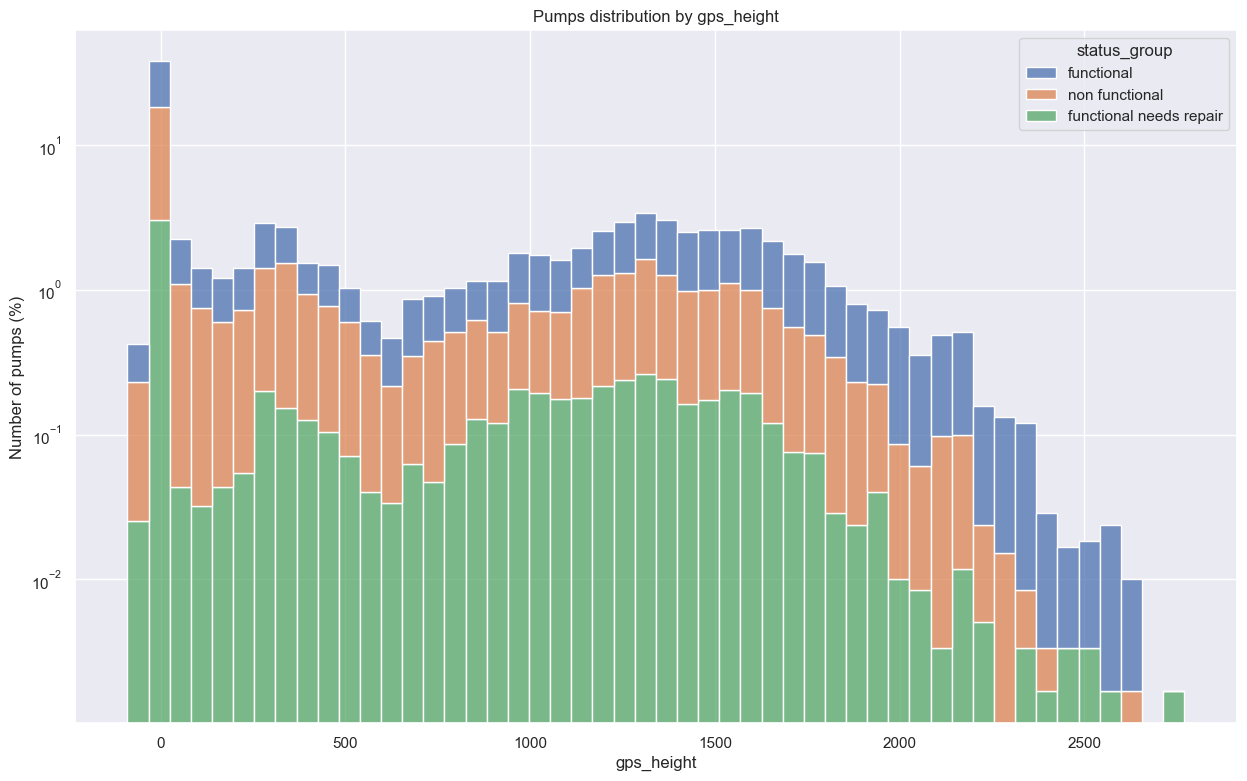

In [61]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.histplot(data=df, x="gps_height", hue="status_group", stat='percent', bins=50, multiple="stack");
plt.yscale('log')
plt.ylabel('Number of pumps (%)');
plt.title('Pumps distribution by gps_height');
plt.show()

### Посмотрим расположение точек на карте

In [62]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 15))
min_lon = 25  # Минимальная долгота
max_lon = 41  # Максимальная долгота
min_lat = -15  # Минимальная широта
max_lat = 0   # Максимальная широта
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

sns.scatterplot(data = df, x = "longitude", y = "latitude", hue='status_group', marker='o',
                s=50, transform=ccrs.PlateCarree(), zorder=3, palette = "dark")
ax.set_title('Точки на карте')

plt.show()

ValueError: Incomplete shapefile definition in 'C:\Users\Анна\.local\share\cartopy\shapefiles\natural_earth\physical\ne_10m_land.shp'.

<Figure size 1500x1500 with 1 Axes>

### Рассмотрим cуммарное количество воды по географическим локациям:

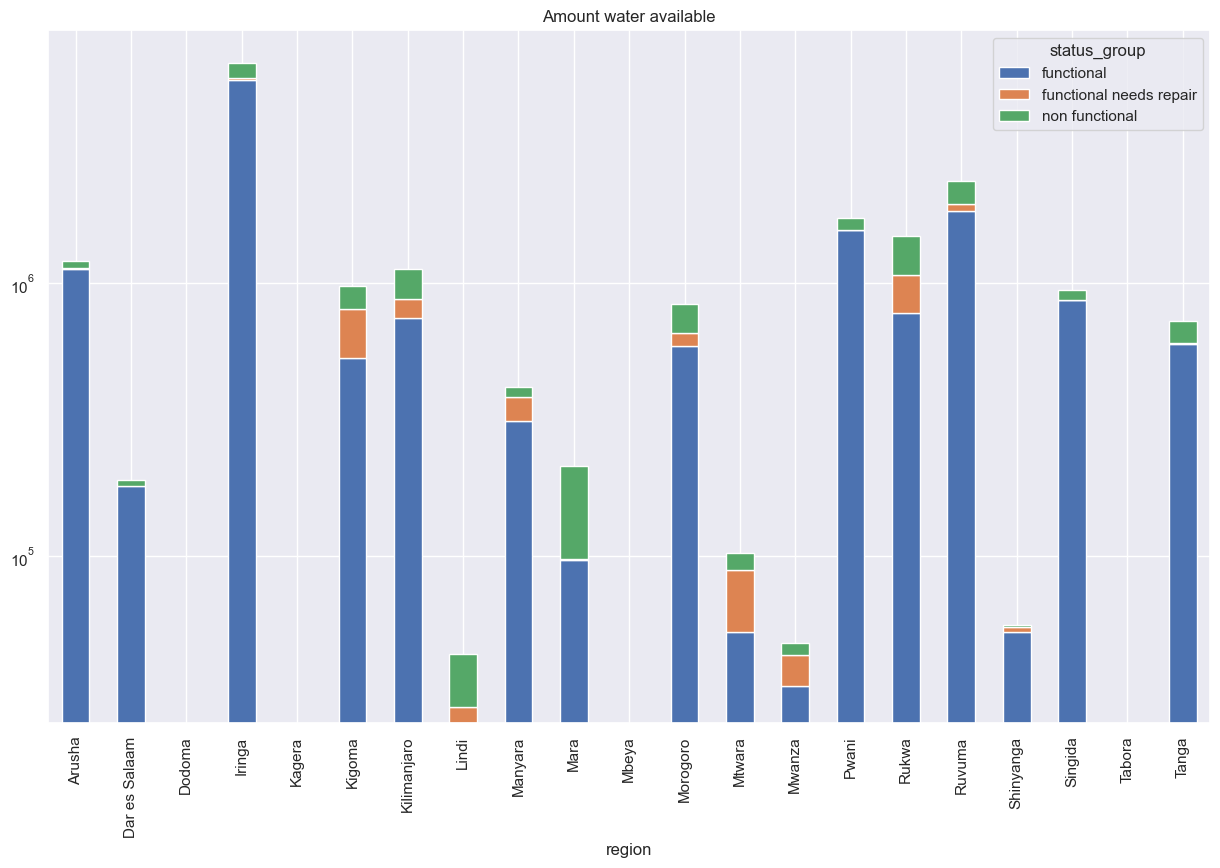

In [63]:
fig, ax = plt.subplots(figsize=(15, 9))


_data = df.groupby(["region", "status_group"])['amount_tsh'].sum().unstack()
_data.plot(kind='bar', stacked=True, ax=ax);
plt.yscale('log')
#plt.ylabel('Number of pumps (%)');
plt.title('Amount water available');
plt.show()

### Видно, что от местности к местности, значения меняются. Поэтому рассмотрим количество воды в насосах на душу населения рядом с насосом в зависимости от региона

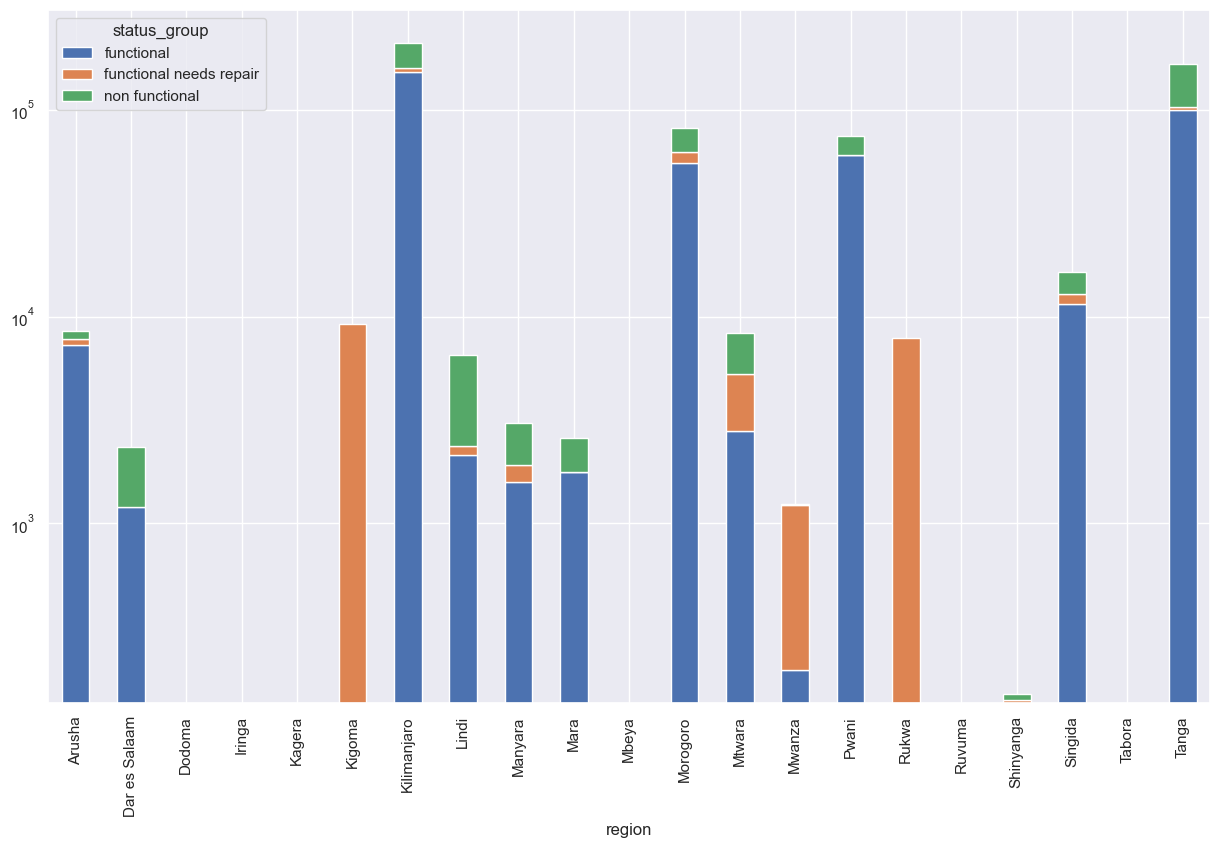

In [64]:
fig, ax = plt.subplots(figsize=(15, 9))

df['amount_per_one'] = df['amount_tsh']/df['population']
_data = df.groupby(["region", "status_group"])
_data = _data.amount_per_one.sum().unstack()
_data.plot(kind='bar', stacked=True, ax=ax);
plt.yscale('log')
plt.show()

### Посмотрим на основные источники водоснабжения

<AxesSubplot:xlabel='source_type', ylabel='count'>

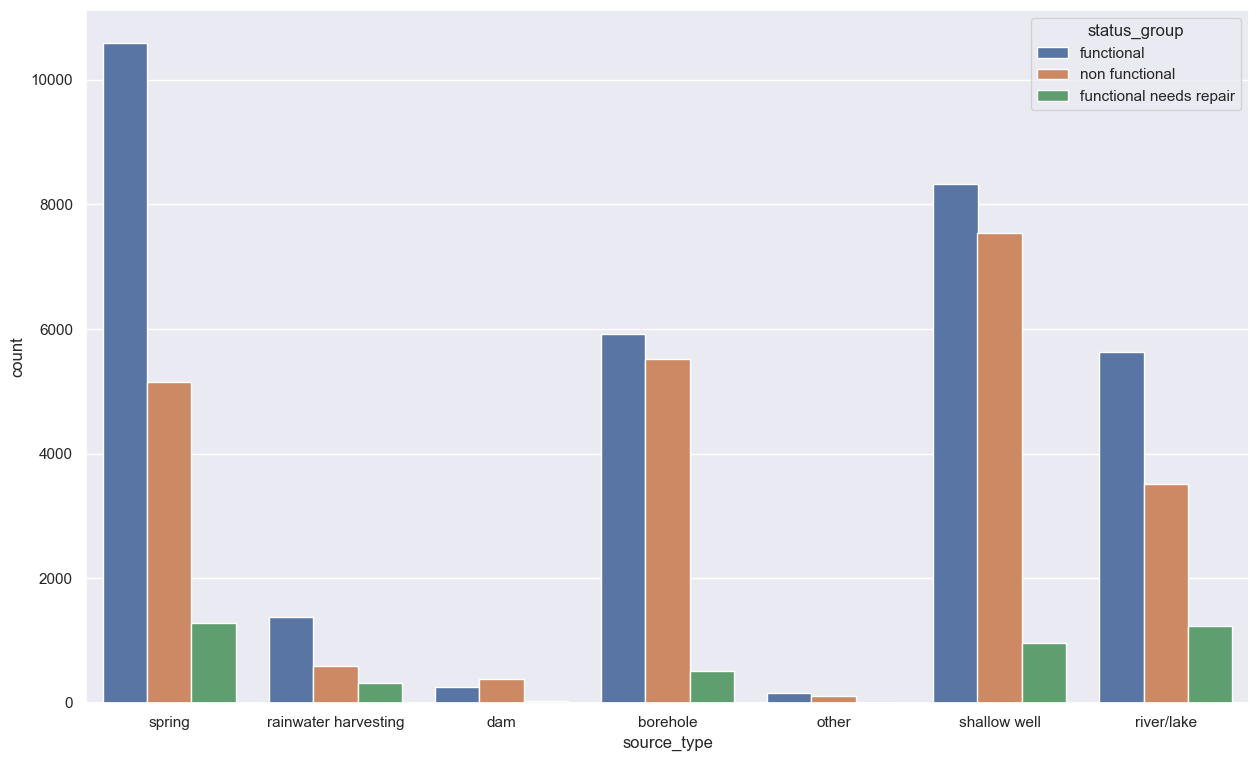

In [65]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.countplot(data = df, x = 'source_type', hue = 'status_group')

Самыми популярными являются родник и неглубокий колодец. Для родников преобладают функционирующие насосы, в то время как для колодцев число функционирующих и нефункционирующих примерно одинаково.

### Определим зависимость функционирования насоса от платежа за воду

<AxesSubplot:xlabel='payment_type', ylabel='count'>

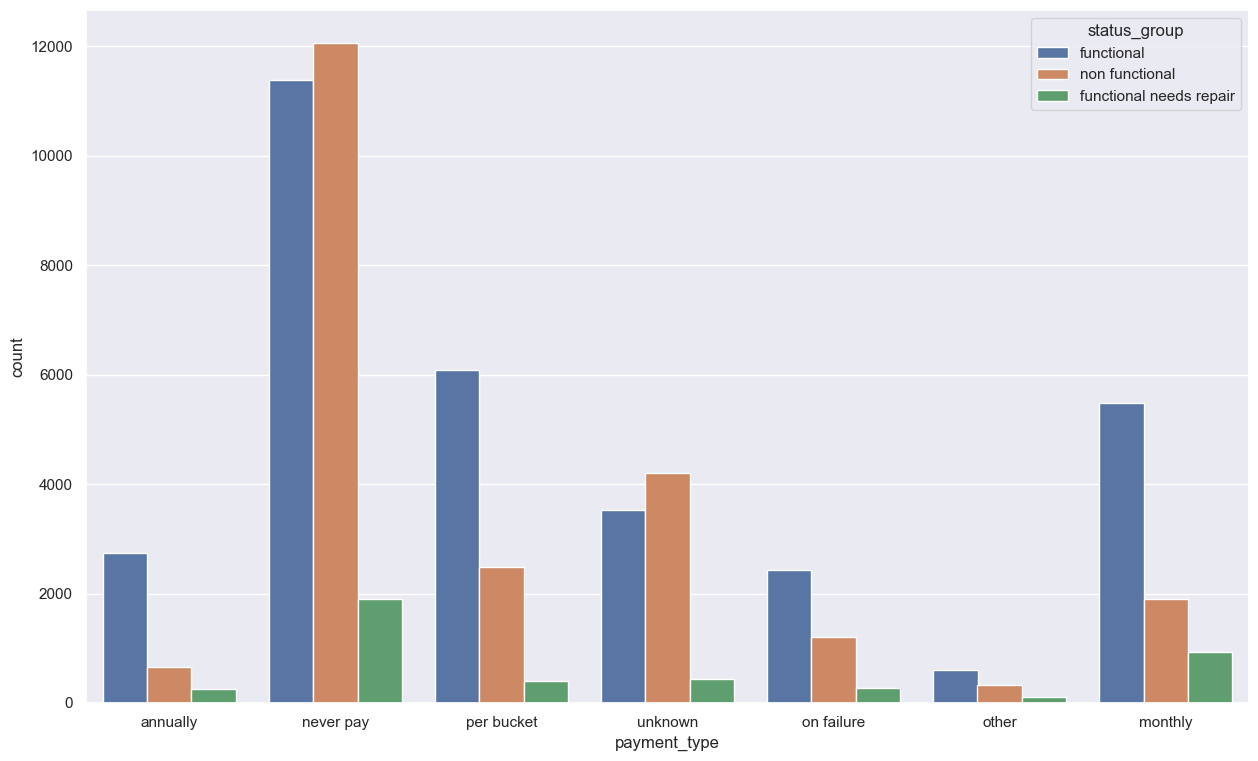

In [66]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.countplot(data = df, x = 'payment_type', hue = 'status_group')

Из графика видно, если оплачивать воду, то часть средств будут уходить на обслуживание точки, и, следовательно, вероятность функционирования точки будет выше.

### Посмотрим распредление качества воды исходя из доступного количества воды

<AxesSubplot:xlabel='quality_group', ylabel='amount_tsh'>

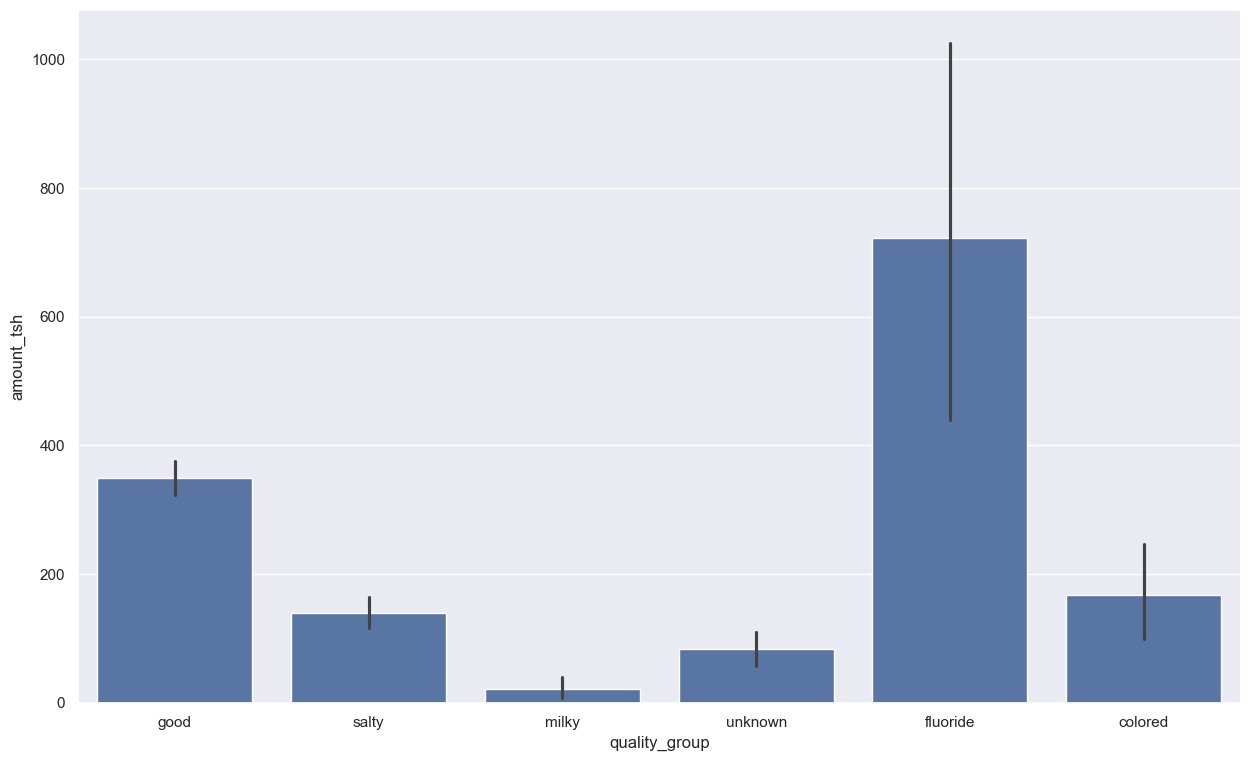

In [67]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.barplot(data=df, x='quality_group', y='amount_tsh')

Можно видеть, что больше всего доступной воды относится к фторсодержащей и хорошей по качеству. Это говорит о том, что большинство воды, которую можно добыть в этих точках, можно использовать как питьевую.

In [68]:
df.shape [0]

59400

In [69]:
#df = df[df.status_group != 'non functional'] 
#df = df[df.status_group != 'functional needs repair'] 
#fig, ax = plt.subplots(figsize=(15, 9))
#sns.barplot(data=df, x='quality_group', y='amount_tsh')

In [70]:
df['amount_tsh'].sum()

18868432.85

In [71]:
# единицы измерения amount_tsh ?

### Рассмотрим распределение функциональных и нефункциональных колодцев среди всего населения Танзании

In [72]:
functional = []
non_functional = []
so_so = []
for i,r in df.iterrows():
    if r['status_group'] == 'functional':
        functional.append(r['population'])
    elif r['status_group'] == 'functional needs repair':
        so_so.append(r['population'])
    else:
        non_functional.append(r['population'])

In [73]:
funct = sum(functional)
nfunct = sum(non_functional)
so = sum(so_so)

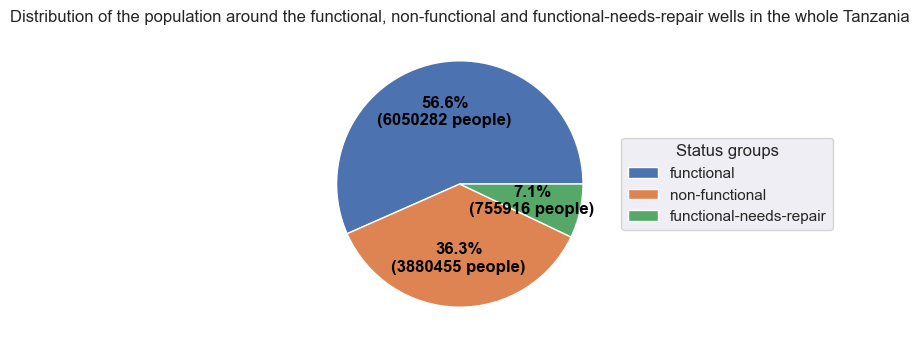

In [74]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))

distribution = ["6050282 functional",
              "3880455 non-functional",
               "755916 functional-needs-repair"]

data = [float(x.split( )[0]) for x in distribution]
wells = [x.split( )[-1] for x in distribution]

def func(pct,allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} people)"

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="black"))

ax.legend(wedges, wells,
          title="Status groups",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Distribution of the population around the functional, non-functional and functional-needs-repair wells in the whole Tanzania")

plt.show()

Из представленной круговой диаграммы видно, что почти половина населения Танзании не имеет доступа к полноценно функционирующим колодцам.

### График, отражающий зависимость колодцев с хорошей водой от общего количества функционирующих колодцев, а также от года постройки колодца

In [75]:
years = []
for i,r in df.iterrows():
    years.append(r.construction_year)
years = np.array(years)
years = np.unique(years)
years = np.delete(years,0)
years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])

In [76]:
res = []
for i in years:
#     mask = (df.construction_year == i) & (df.status_group == 'functional') & (df.quality_group == 'colored')
    mask = (df.construction_year == i) & (df.status_group == 'functional')
    a = []
    for i,r in df[mask].iterrows():
        a.append(i)
    res.append(len(a))

In [77]:
tdf = pd.DataFrame()
tdf['years'] = years
tdf['good_water_wells'] = [22,2,7,31,7,10,3,29,19,15,90,50,175,50,227,132,79,58,413,
                                          32,239,73,225,163,318,305,196,131,225,151,443,132,340,265,356,
                                          555,342,241,501,668,1182,308,634,785,643,527,806,956,1673,1569,1778,824,639,96]
tdf['salty_water_wells'] = [0,0,0,0,0,0,3,0,0,0,4,20,2,2,6,11,5,2,12,9,12,10,7,20,45,19,14,
                                           11,15,13,16,7,20,19,20,31,36,30,26,24,72,19,39,30,47,41,60,89,116,165,207,102,56,2]
tdf['milky_water'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,1,3,2,1,2,
                                           1,0,2,1,0,3,3,3,2,1,5,7,6,2,1,0]
tdf['fluoried_water'] = [2,0,0,0,0,0,0,2,3,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,
                                              0,0,0,1,0,0,14,2,0,8,1,8,2,2,2,6,19,18,10,8,4,9,1]
tdf['coloured_water'] = [0,0,0,0,0,1,0,0,0,0,0,12,0,2,0,0,0,0,0,0,1,2,2,1,1,0,1,0,2,0,1,0,
                                              0,0,0,1,3,3,12,1,3,1,8,3,7,2,5,12,9,14,15,6,3,0]
tdf['functional_wells'] = [24,2,7,31,7,11,6,31,22,15,99,82,178,55,234,144,85,62,426,41,258,85,236,187,365,324,212,143,245,
                          165,466,141,361,285,380,593,386,291,542,694,1279,331,692,828,704,578,883,1081,1839,1774,2023,
                          943,726,102]

<AxesSubplot:xlabel='years', ylabel='functional_wells'>

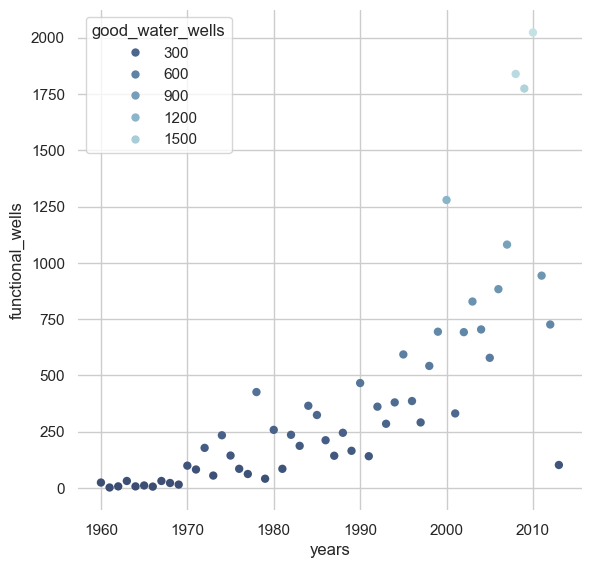

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Load the example diamonds dataset
# diamonds = sns.load_dataset("diamonds")
diamonds = tdf
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="years", y="functional_wells",
                hue="good_water_wells",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=diamonds, ax=ax)

Из графика видно, что с течением времени количество функционирующих колодцев с хорошей водой увеличивалось.

### Рассмотрим распределние добычи воды на декаду

In [79]:
res = []
for i in years:
#     mask = (df.construction_year == i) & (df.status_group == 'functional') & (df.quality_group == 'colored')
    mask = (df.construction_year == i) & (df.status_group == 'functional') & (df.extraction_type_class == 'wind-powered')
    a = []
    for i,r in df[mask].iterrows():
        a.append(i)
    res.append(len(a))
res = np.array(res)
res

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 2, 0, 1, 0, 1, 6, 1, 1, 0])

In [80]:
tdf3 = pd.DataFrame()
tdf3['years'] = years
tdf3['gravity'] = [17,    1,    5,   31,    6,   10,    2,   31,   20,   15,   71,
         70,  162,   40,  188,  122,   50,   35,  373,   22,  168,   45,
        126,  126,  228,  206,  136,   88,  136,  105,  237,   49,  287,
        149,  207,  383,  148,   84,  344,  561,  601,  244,  541,  464,
        357,  321,  487,  674, 1130,  983,  733,  501,  418,   90]
tdf3['handpump'] = [0,   0,   1,   0,   0,   1,   1,   0,   0,   0,   3,   2,   2,
         3,  12,   9,  20,   8,  14,  12,  60,  25,  57,  48,  73,  80,
        66,  47,  76,  50, 204,  73,  52, 119, 138, 194, 201, 142, 149,
       109, 248,  61,  86, 152, 197, 136, 190, 219, 303, 419, 391, 208,
       152,   3]
tdf3['motorpump'] = [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  12,   0,   2,
         0,  21,   5,   1,   1,  14,   4,   3,   3,   0,   0,   0,   1,
         4,   2,   7,   5,   6,   1,   0,   0,   2,   0,   2,   1,   6,
         2,  62,   7,   4,  16,  12,  20,  33,  13,  57,  48, 134,  38,
        35,   0]
tdf3['rope_pump'] = [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  5,  1,
        2,  0,  0,  1,  3,  3,  7,  2,  2,  6,  4,  8,  9, 18, 47, 46, 61,
       34, 13,  0]
tdf3['submersible'] = [5,   1,   0,   0,   0,   0,   3,   0,   0,   0,  10,   3,  11,
        12,  10,   8,  12,  18,  21,   1,  18,   4,  45,   7,  56,  26,
         5,   3,  25,   4,  12,   8,  13,  12,  21,   7,   6,  53,  28,
        10, 305,  14,  46, 179, 120,  71, 150, 138, 272, 210, 617, 135,
        89,   6]
tdf3['wind_powered'] = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 2, 0, 1, 0, 1, 6, 1, 1, 0]
tdf3['functional_wells'] = [24,2,7,31,7,11,6,31,22,15,99,82,178,55,234,144,85,62,426,41,258,85,236,187,365,324,212,143,245,
                          165,466,141,361,285,380,593,386,291,542,694,1279,331,692,828,704,578,883,1081,1839,1774,2023,
                          943,726,102]

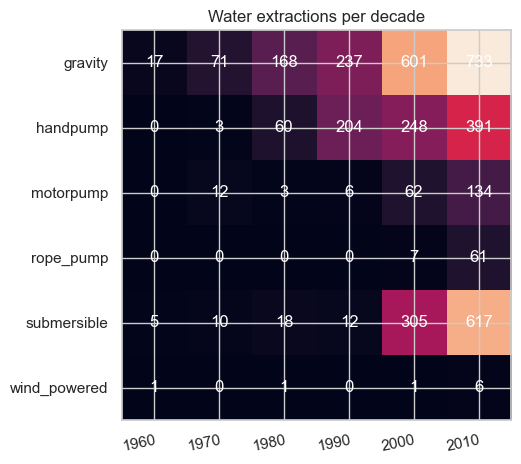

In [81]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


extraction_types = ["gravity", "handpump", "motorpump", "rope_pump",
              "submersible", "wind_powered"]
years = [1960,1970,1980,1990,2000,2010]

harvest = np.array([[17, 71, 168,   237,  601, 733],
                    [0,3,60,204,248,391],
                    [0,12,3,6,62,134],
                    [0,0,0,0,7,61],
                    [5,10,18,12,305,617],
                    [1,0,1,0,1,6]])


fig, ax = plt.subplots()

im = ax.imshow(harvest)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(years)), labels=years)
ax.set_yticks(np.arange(len(extraction_types)), labels=extraction_types)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=12, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(extraction_types)):
    for j in range(len(years)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Water extractions per decade")
fig.tight_layout()
plt.show()

